### INTRODUCTION
---
* The aim of this notebook is to show how a few lines of code in python using Pandas, NumPy and Matplotlib help perform statistical analysis on a dataset with apparently minimal information.

### APPLICATION OF STATISTICAL INFERENCE ON A REAL DATA SET WITH AN EMPHASIS ON:
---
* Poisson Process
* Exponential Distribution
* Bootstrap Sampling
* Confidence Interval

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

plt.style.use('_classic_test_patch')
sns.set_style('whitegrid')

In [2]:
data = pd.read_csv('../input/pipeline-accidents/database.csv')
cols_of_interest = ['Accident Date/Time','Accident State','Pipeline Location','Liquid Type','Net Loss (Barrels)','All Costs']
data = data[cols_of_interest]

In [3]:
#show dataframe
data.head()

,Accident Date/Time,Accident State,Pipeline Location,Liquid Type,Net Loss (Barrels),All Costs
0,1/1/2010 7:15 AM,KS,ONSHORE,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",21.0,1627
1,1/4/2010 8:30 AM,ME,ONSHORE,CRUDE OIL,0.0,4008
2,1/5/2010 10:30 AM,LA,ONSHORE,"HVL OR OTHER FLAMMABLE OR TOXIC FLUID, GAS",2.0,200
3,1/6/2010 7:30 PM,WI,ONSHORE,CRUDE OIL,0.0,11540
4,1/7/2010 1:00 PM,TX,ONSHORE,CRUDE OIL,2.0,29650


#### SUMMARY StATISTICS OF QUANTITATIVE FEATURES

In [4]:
data[['Net Loss (Barrels)', 'All Costs']].describe()

,Net Loss (Barrels),All Costs
count,2795.000000,2.795000e+03
mean,132.194050,8.340332e+05
std,1185.019252,1.657830e+07
min,0.000000,0.000000e+00
25%,0.000000,5.039500e+03
50%,0.000000,2.312900e+04
75%,2.000000,1.172325e+05
max,30565.000000,8.405261e+08


### INSIGHTS
* Both our variables presence of extreme values can easily be inferred because of extremely large MAX values as compared to their means.
* Large standard deviation indicates a large variance from the mean values of the features.

In [5]:
#minimize the staandard deviation by dividing it to 1000000
data['All Costs'] = data['All Costs'] / 1000000
#convert data to pandas datetime object
data['Accident Date/Time'] = pd.to_datetime(data['Accident Date/Time'])

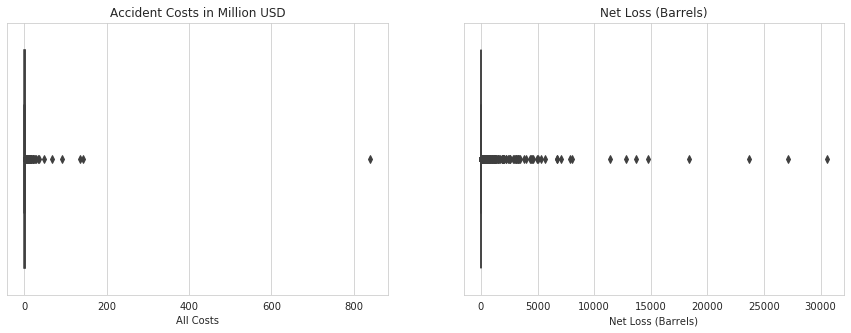

In [6]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

sns.boxplot(data['All Costs'], ax=ax[0]);
sns.boxplot(data['Net Loss (Barrels)'], ax=ax[1]);

ax[0].set_title('Accident Costs in Million USD');
ax[1].set_title('Net Loss (Barrels)');

### INSIGHTS
---
* The absence of the box in the box plot for both variables clearly indicate that the max values for both variables are significantly larger than the rest of the sample.
* The distribution of the data is highly unreliable. With such a distribution, fitting a model to the variable is difficult unless the extreme values can be eliminated.

### NUMBER OF ACCIDENTS

In [7]:
totalTimespan = data['Accident Date/Time'].max() - data['Accident Date/Time'].min()
totaltime_hour = (totalTimespan.days*24 + totalTimespan.seconds/(3600))
totaltime_month = (totalTimespan.days + totalTimespan.seconds/(3600*24)) *12/365

lmda_h = len(data) / totaltime_hour
lmda_d = len(data) / totalTimespan.days
lmda_m = len(data) / totaltime_month

print('Number of Accidents per Hour: ', lmda_h);
print('Number of Accidents per Day: ', lmda_d);
print('Number of Accidents per Month: ', lmda_m);

Number of Accidents per Hour:  0.04540255169379675
Number of Accidents per Day:  1.0896686159844056
Number of Accidents per Month:  33.14386273647162


### MODELLING THE FREQUENCY OF ACCIDENTS IN A CERTAIN INTERVAL

In [8]:
PX = {}
#calculate poisson probabilities from range 0-66
for x in range(66):
    PX[x] = math.pow(2.71828, -33) * math.pow(33, x) / math.factorial(x)
p_poisson = pd.DataFrame(PX.items(), columns=['X', 'PX'])


#commulative distribution function
def cdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x,y

np.random.seed(101)
samples_poisson = np.random.poisson(33, 5000)
x,y = cdf(samples_poisson)

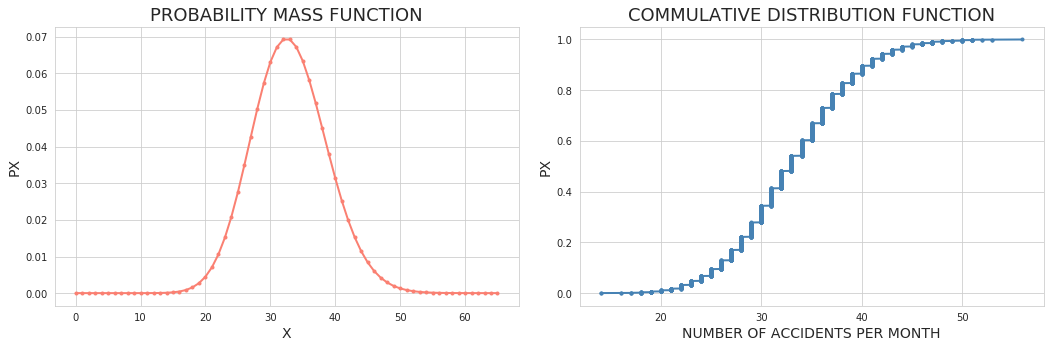

<Figure size 720x360 with 0 Axes>

In [9]:
#show probability mass function
fig, ax = plt.subplots(1,2, figsize=(15,5))
plt.tight_layout(3)
ax[0].set_title('PROBABILITY MASS FUNCTION', fontsize=18);
ax[0].set_xlabel('X', fontsize=14);
ax[0].set_ylabel('PX', fontsize=14);
ax[0].plot(p_poisson.X, p_poisson.PX, lw=2, marker='.', color='salmon');

#show commulative distribution function
plt.figure(figsize=(10,5))
ax[1].set_title('COMMULATIVE DISTRIBUTION FUNCTION', fontsize=18);
ax[1].set_xlabel('NUMBER OF ACCIDENTS PER MONTH', fontsize=14)
ax[1].set_ylabel('PX', fontsize=14);
ax[1].plot(x, y, lw=2, marker='.', color='steelblue');

### INSIGHTS
---
* With the probability mass function plot, we can tell that there's only a 7% chance that 33 accidents will occur in a month even though the mean number of accicents per month is 33.
* The cumulative distribution function tells us that there is a 50% chance of 33 or less accidents occurring per month or there is a 50% chance of 33 or more accidents occurring per month which is not intuitive by only knowing the mean.

### MEAN TIME BETWEEN ACCIDENTS

In [10]:
data.sort_values(by=['Accident Date/Time'], ascending = True, inplace = True)
data['timetoAccident'] = data['Accident Date/Time'].diff() #compute time between each accident
data['timetoAccident_h'] = data.apply(lambda x: x['timetoAccident'].days * 24 + x['timetoAccident'].seconds/3600, axis = 1)
data= data[data.timetoAccident.notnull()]

mean_time = np.mean(data['timetoAccident_h']) #parameter for exponential distribution
print('Mean time between accidents: ', mean_time)

Mean time between accidents:  22.03307683130523


### EXPONENTIAL DISTRIBUTION
* To model the time elapses before an event occurs.

In [11]:
x,y = cdf(data['timetoAccident_h'])
#get 5000 exponential smaples
samples_exp = np.random.exponential(mean_time, 5000)
x_exp, y_exp = cdf(samples_exp)

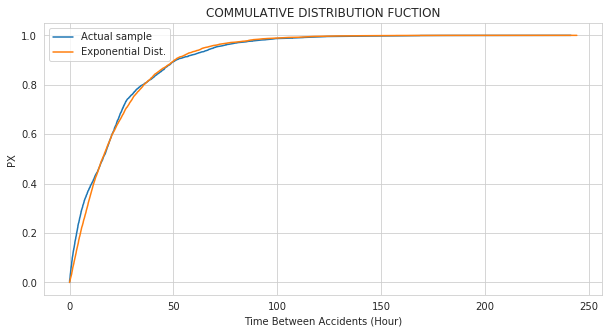

In [12]:
plt.figure(figsize=(10,5))

plt.plot(x, y);
plt.plot(x_exp, y_exp);
plt.title('COMMULATIVE DISTRIBUTION FUCTION');
plt.xlabel('Time Between Accidents (Hour)');
plt.ylabel('PX');

plt.legend(['Actual sample', 'Exponential Dist.']);

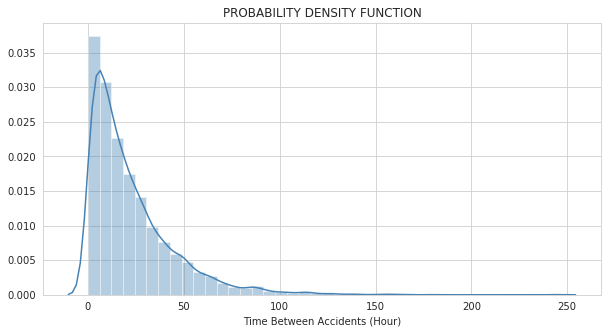

In [13]:
plt.figure(figsize=(10,5))
plt.title('PROBABILITY DENSITY FUNCTION');
plt.xlabel('Time Between Accidents (Hour)');
sns.distplot(samples_exp, bins=40, color='steelblue');

### INSIGHTS
---
* The above graph shows the cumulative distributions for the sample data for accidents is very similar to the cumulative distribution of a random sample from an exponential distribution with the same mean as mean time to accidents.
* It would be appropriate to model time between oil pipeline accidents with an exponential distribution.
* The probability density function of oil pipeline accidents sample is an exponential decay.

### BOOTSTRAP SAMPLING
* To resample the data and perform statistical inference.

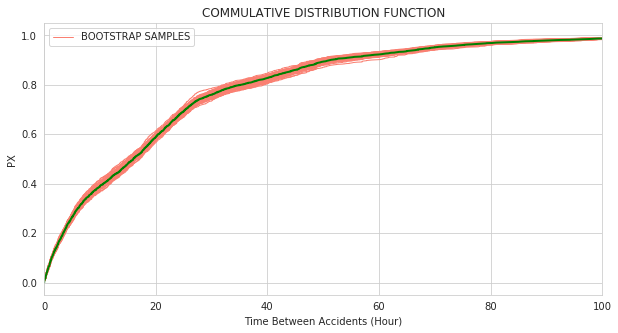

In [14]:
plt.figure(figsize = (10,5))
plt.xlim([0,100])

for i in range(100):
    samples_bs = np.random.choice(data['timetoAccident_h'], size = len(data['timetoAccident_h']))
    x_bs,y_bs = cdf(samples_bs)
    plt.plot(x_bs,y_bs, lw=1, color='salmon')

x,y = cdf(data['timetoAccident_h'])
plt.plot(x,y, lw=2, color='green',)
plt.title('COMMULATIVE DISTRIBUTION FUNCTION')
plt.xlabel('Time Between Accidents (Hour)');
plt.ylabel('PX');
plt.legend(['BOOTSTRAP SAMPLES']);

### INSIGHTS
---
* The distribution of 100 bootstrap samples is plotted on top of the actual data and as expected, the samples vary slightly from the actual sample while still closely maintaining the exponential distribution.

### CONFIDENCE INTERVAL

#### BOOTSTRAP REPLICATE FUNCTION

In [15]:
def bs_replicate(data, func):
    samples_bs = np.random.choice(data, size=len(data))
    return func(samples_bs)
def draw_bs_replicate(data, func, size):
    replicates = np.empty(size)
    
    for i in range(size):
        replicates[i] = bs_replicate(data, func)
    return replicates

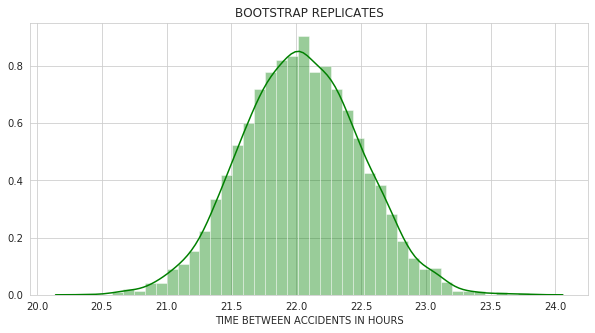

In [16]:
bootstrap_replicates = draw_bs_replicate(data['timetoAccident_h'], np.mean, 5000)
plt.figure(figsize=(10,5))
plt.title('BOOTSTRAP REPLICATES')
plt.xlabel('TIME BETWEEN ACCIDENTS IN HOURS')
sns.distplot(bootstrap_replicates, bins=40, color='green');

### INSIGHTS
---
* The histogram in the above plot shows the probability density of the bootstrap replicates or the mean time to accidents when the process was repeated 5,000 times.

### FOR 95% CONFIDENCE INTERVAL
* We need to find the range where 95% of times the mean of our replicates falls. That’s simply all values between the 2.5th and the 97.5th percentile of the bootstrap replicates

In [17]:
confidence_int = np.percentile(bootstrap_replicates, [2.5,97.5])
print('95% confidence interval: ', confidence_int[0], '-',confidence_int[1], '(Hours)')

95% confidence interval:  21.13713866022429 - 22.926513660224288 (Hours)


In [18]:
accidents_pyear = [round((confidence_int[0]/24)*365), round((confidence_int[1]/24)*365)]
print('Number of Accidents per year: ', accidents_pyear[0], '-', accidents_pyear[1])

Number of Accidents per year:  321.0 - 349.0


### ANNUAL COST OF OIL PIPELINE ACCIDENTS

In [19]:
annual_cost = [(data['All Costs'].median())*321*1000000, (data['All Costs'].median())*349*1000000]

print('ANNUAL COST OF OIL PIPELINE ACCIDENTS: ', round(annual_cost[0]), '-', round(annual_cost[1]), 'USD')

ANNUAL COST OF OIL PIPELINE ACCIDENTS:  7427780 - 8075686 USD


### CONCLUSION
---
* With this analysis, we have 95% confidence that it takes between 21.14 and 22.93 hours for an oil pipeline accident to occur in the US or we have 95% confidence that about 321 to 349 oil pipeline accidents occur every year in the US.
* We have 95% confidence that the annual cost incurred due to oil pipeline accidents in USA is between 7.43 to 8.06 million US dollars.